# Лабораторная работа 4. Обучение и модели линейной регрессии

## Задание 1

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")

# Часть 0. Введение в линейные модели

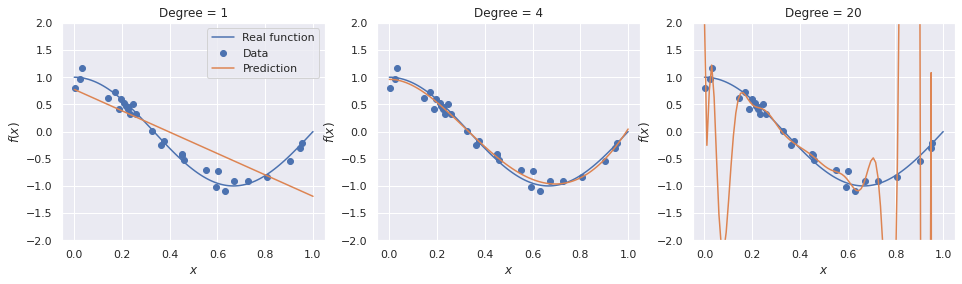

In [2]:
from sklearn.linear_model import LinearRegression

np.random.seed(36)
x = np.linspace(0, 1, 100)
y = np.cos(1.5 * np.pi * x)

x_objects = np.random.uniform(0, 1, size=30)
y_objects = np.cos(1.5 * np.pi * x_objects) + np.random.normal(scale=0.1, size=x_objects.shape)

from sklearn.preprocessing import PolynomialFeatures
fig, axs = plt.subplots(figsize=(16, 4), ncols=3)
for i, degree in enumerate([1, 4, 20]):
    X_objects = PolynomialFeatures(degree, include_bias=False).fit_transform(x_objects[:, None])
    X = PolynomialFeatures(degree, include_bias=False).fit_transform(x[:, None])
    regr = LinearRegression().fit(X_objects, y_objects)
    y_pred = regr.predict(X)
    axs[i].plot(x, y, label="Real function")
    axs[i].scatter(x_objects, y_objects, label="Data")
    axs[i].plot(x, y_pred, label="Prediction")
    if i == 0:
        axs[i].legend()
    axs[i].set_title("Degree = %d" % degree)
    axs[i].set_xlabel("$x$")
    axs[i].set_ylabel("$f(x)$")
    axs[i].set_ylim(-2, 2)

#### Вопрос 2: Почему большие веса в линейной модели — плохо?

#### Вопрос 3: Почему регуляризовать w0 — плохая идея?

#### Вопрос 4: На что влияет коэффициент λ? Что будет происходить с моделью, если λ начать уменьшать? Что будет, если λ сделать слишком большим?

## Часть 1. Загружаем данные

In [3]:
!wget  -O 'train_sem2.csv' -q 'https://www.dropbox.com/s/6dxq90t0prn2vaw/_train_sem2.csv?dl=0'

In [4]:
data = pd.read_csv("train_sem2.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
data.shape

(1460, 81)

In [6]:
data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

#### Вопрос 1: Почему поля типа id могут вызвать переобучение модели (не обязательно линейной)?

#### Вопрос 2: Почему стоит дополнительно отделять валидационную выборку?

#### Вопрос 3: Обратите внимание на фиксацию random_state при сплите данных. Почему это важно?

In [7]:
from sklearn.model_selection import train_test_split

data = data.drop(columns=["Id"])

y = data["SalePrice"]
X = data.drop(columns=["SalePrice"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

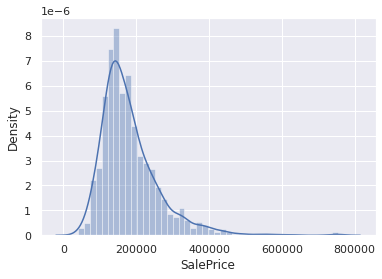

In [8]:
sns.distplot(y_train)

#### Вопрос: Что означает, что коэффициент корреляции Пирсона между двумя случайными величинами равен 1? -1? 0?

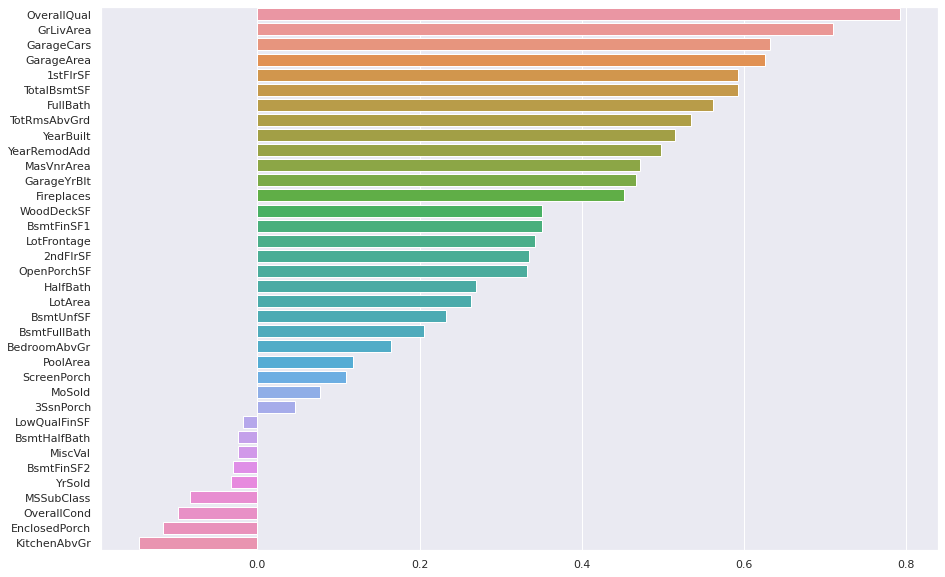

In [9]:
numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)

correlations = X_train[numeric_features].corrwith(y_train).sort_values(ascending=False)


plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 10)

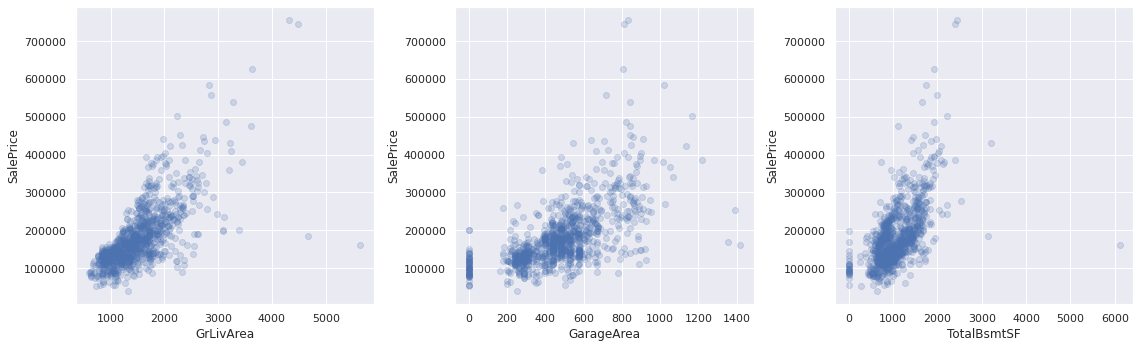

In [10]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=3)
for i, feature in enumerate(["GrLivArea", "GarageArea", "TotalBsmtSF"]):
    axs[i].scatter(X_train[feature], y_train, alpha=0.2)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("SalePrice")
plt.tight_layout()

## Часть 2. Первая модель

In [11]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge()
model.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
y_train_pred = model.predict(X_train[numeric_features])

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 32085.7681
Train RMSE = 35631.3131


In [12]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train[numeric_features], y_train, cv=10, scoring="neg_root_mean_squared_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV MSE = %.4f" % np.mean(-cv_scores))

Cross validation scores:
	 -38825.3172
	-45278.9230
	-31405.3380
	-33890.1048
	-73848.3061
	-24142.7915
	-45523.7066
	-52861.2908
	-26094.3376
	-29693.5005
Mean CV MSE = 40156.3616


#### Вопрос: Почему оптимизация RMSE эквивалентна оптимизации MSE?

In [13]:
from sklearn.metrics import make_scorer

def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

rmse_scorer = make_scorer(
    rmse,
    greater_is_better=False
)

In [14]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train[numeric_features], y_train, cv=10, scoring=rmse_scorer)
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV RMSE = %.4f" % np.mean(-cv_scores))

Cross validation scores:
	 -38825.3172
	-45278.9230
	-31405.3380
	-33890.1048
	-73848.3061
	-24142.7915
	-45523.7066
	-52861.2908
	-26094.3376
	-29693.5005
Mean CV RMSE = 40156.3616


In [15]:
best_constant = y_train.mean()
print("Test RMSE with best constant = %.4f" % mean_squared_error(y_test, best_constant * np.ones(y_test.shape),
                                                                 squared=False))
print("Train RMSE with best constant = %.4f" % mean_squared_error(y_train, best_constant * np.ones(y_train.shape),
                                                                  squared=False))

Test RMSE with best constant = 76636.5188
Train RMSE with best constant = 80588.6191


In [16]:
def show_weights(features, weights, means, scales):
    fig, axs = plt.subplots(figsize=(14, 10), ncols=3)
    sorted_weights = sorted(zip(weights, features, means, scales), reverse=True)
    weights, features, means, scales = zip(*sorted_weights)
    features = list(features)
    
    sns.barplot(y=features, x=list(weights), ax=axs[0])
    axs[0].set_xlabel("Weight")
    sns.barplot(y=features, x=list(means), ax=axs[1])
    axs[1].set_xlabel("Mean")
    sns.barplot(y=features, x=list(scales), ax=axs[2])
    axs[2].set_xlabel("Scale")
    plt.tight_layout()

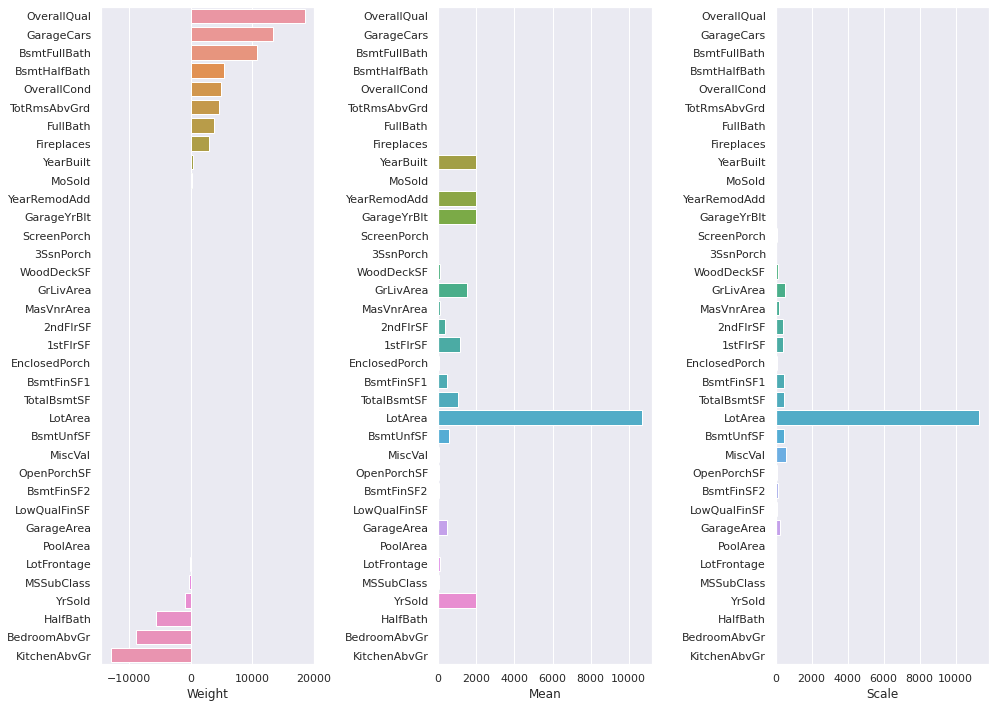

In [17]:
show_weights(numeric_features, model.coef_, X_train[numeric_features].mean(), X_train[numeric_features].std())

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

model = Ridge()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 32085.3150
Train RMSE = 35631.2160


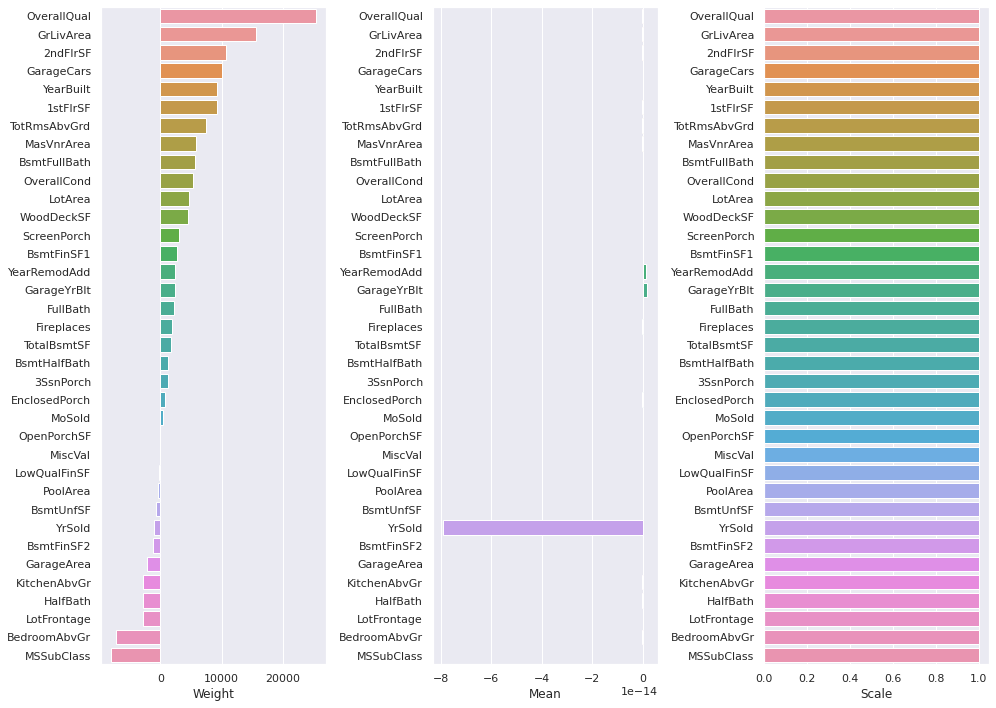

In [19]:
means = pd.Series(data=X_train_scaled.mean(axis=0), index=numeric_features)
scales = pd.Series(data=X_train_scaled.std(axis=0), index=numeric_features)
show_weights(numeric_features, model.coef_, means, scales)

Best alpha = 297.6351


Text(0, 0.5, 'CV score')

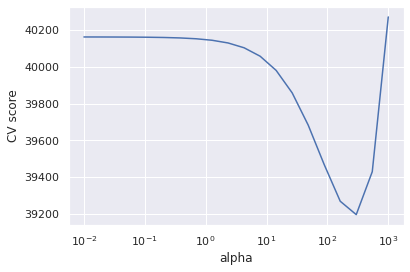

In [20]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(X_train_scaled, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [21]:
from sklearn.pipeline import Pipeline

simple_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('regression', Ridge(best_alpha))
])

model = simple_pipeline.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 31703.3590


## Часть 3. Работаем с категориальными признаками

In [22]:
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
X_train[categorical] = X_train[categorical].fillna("NotGiven")
X_test[categorical] = X_test[categorical].fillna("NotGiven")

In [23]:
X_train[categorical].sample(5)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
184,RL,Pave,NotGiven,IR1,Lvl,AllPub,Inside,Gtl,BrkSide,RRAn,...,Attchd,Unf,TA,TA,Y,NotGiven,MnPrv,NotGiven,WD,Normal
837,RM,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,BrDale,Norm,...,Detchd,Unf,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
1094,RL,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Fin,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
1291,RM,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,BrDale,Norm,...,Detchd,Unf,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
436,RM,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,...,Detchd,Unf,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal


In [24]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 26282.3915


In [25]:
print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer.transform(X_train).shape)

Size before OneHot: (1022, 79)
Size after OneHot: (1022, 294)


In [26]:
from sklearn.linear_model import Lasso

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model = lasso_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

RMSE = 26468.4015


In [27]:
ridge_zeros = np.sum(pipeline.steps[-1][-1].coef_ == 0)
lasso_zeros = np.sum(lasso_pipeline.steps[-1][-1].coef_ == 0)
print("Zero weights in Ridge:", ridge_zeros)
print("Zero weights in Lasso:", lasso_zeros)

Zero weights in Ridge: 0
Zero weights in Lasso: 29


In [ ]:
alphas = np.logspace(-2, 4, 20)
searcher = GridSearchCV(lasso_pipeline, [{"regression__alpha": alphas}],
                        scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [29]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 25961.3310


In [30]:
lasso_zeros = np.sum(pipeline.steps[-1][-1].coef_ == 0)
print("Zero weights in Lasso:", lasso_zeros)

Zero weights in Lasso: 221


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

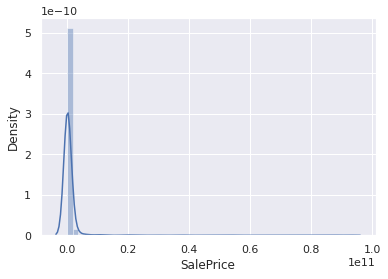

In [31]:
error = (y_train - model.predict(X_train)) ** 2
sns.distplot(error)

In [32]:
mask = (error < np.quantile(error, 0.95))

In [33]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha))
])

model = pipeline.fit(X_train[mask], y_train[mask])
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 25391.0238


In [34]:
X_train = X_train[mask]
y_train = y_train[mask]

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

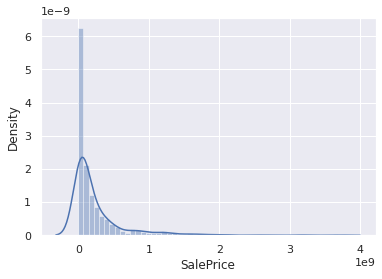

In [35]:
error = (y_train[mask] - model.predict(X_train[mask])) ** 2
sns.distplot(error)

## Часть 4. Подготовка данных для линейных моделей

In [36]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 23629.6630


Text(0, 0.5, 'SalePrice')

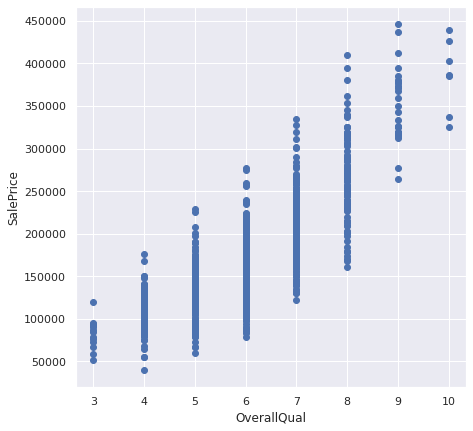

In [37]:
plt.figure(figsize=(7, 7))
plt.scatter(X_train.OverallQual, y_train)
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')

In [38]:
threshold = 5
mask = (X_train.OverallQual <= threshold)
X_train_1 = X_train[mask]
y_train_1 = y_train[mask]
X_train_2 = X_train[~mask]
y_train_2 = y_train[~mask]

In [39]:
column_transformer1 = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline1 = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer1),
    ('regression', Ridge())
])

column_transformer2 = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline2 = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer2),
    ('regression', Ridge())
])



model1 = pipeline1.fit(X_train_1, y_train_1)
model2 = pipeline2.fit(X_train_2, y_train_2)

y_pred_1 = model1.predict(X_test)
y_pred_2 = model2.predict(X_test)
mask_test = (X_test.OverallQual <= threshold)
y_pred = y_pred_1.copy()
y_pred[~mask_test] = y_pred_2[~mask_test]

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 22966.0813


In [40]:
from sklearn.preprocessing import KBinsDiscretizer

(-2.0, 2.0)

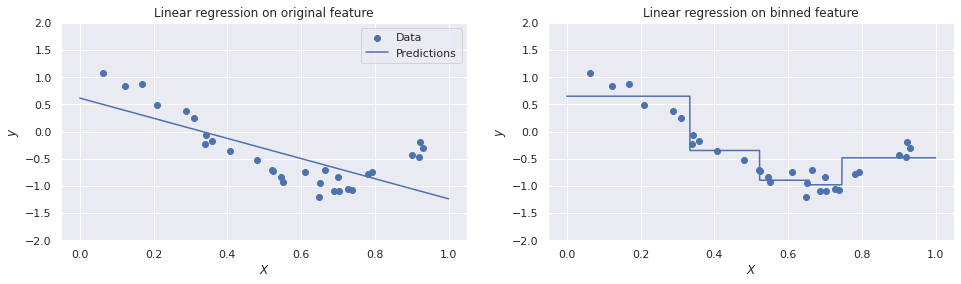

In [41]:
x_plot = np.linspace(0, 1, 10000)

X = np.random.uniform(0, 1, size=30)
y = np.cos(1.5 * np.pi * X) + np.random.normal(scale=0.1, size=X.shape)

fig, axs = plt.subplots(figsize=(16, 4), ncols=2)

regr = LinearRegression()
regr.fit(X[:, np.newaxis], y)
y_pred_regr = regr.predict(x_plot[:, np.newaxis])
axs[0].scatter(X[:, np.newaxis], y, label="Data")
axs[0].plot(x_plot, y_pred_regr, label="Predictions")
axs[0].legend()
axs[0].set_title("Linear regression on original feature")
axs[0].set_xlabel("$X$")
axs[0].set_ylabel("$y$")
axs[0].set_ylim(-2, 2)

binner = KBinsDiscretizer(n_bins=5, strategy='quantile')
pipeline = Pipeline(steps=[
    ('binning', binner),
    ('regression', LinearRegression())
])
pipeline.fit(X[:, np.newaxis], y)
y_pred_binned = pipeline.predict(x_plot[:, np.newaxis])
axs[1].scatter(X[:, np.newaxis], y, label="Data")
axs[1].plot(x_plot, y_pred_binned, label="Predictions")
axs[1].set_title("Linear regression on binned feature")
axs[1].set_xlabel("$X$")
axs[1].set_ylabel("$y$")
axs[1].set_ylim(-2, 2)

Text(0, 0.5, '$y$')

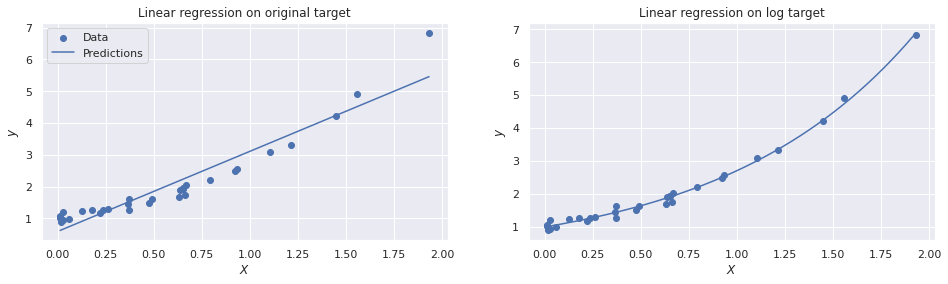

In [42]:
X = np.random.exponential(1, size=30)
y = np.exp(X) + np.random.normal(scale=0.1, size=X.shape)

x_plot = np.linspace(np.min(X), np.max(X), 10000)

fig, axs = plt.subplots(figsize=(16, 4), ncols=2)

regr = LinearRegression()
regr.fit(X[:, np.newaxis], y)
y_pred_regr = regr.predict(x_plot[:, np.newaxis])
axs[0].scatter(X[:, np.newaxis], y, label="Data")
axs[0].plot(x_plot, y_pred_regr, label="Predictions")
axs[0].legend()
axs[0].set_title("Linear regression on original target")
axs[0].set_xlabel("$X$")
axs[0].set_ylabel("$y$")

y_log = np.log(y)
regr.fit(X[:, np.newaxis], y_log)
y_pred_log = np.exp(regr.predict(x_plot[:, np.newaxis]))
axs[1].scatter(X[:, np.newaxis], y, label="Data")
axs[1].plot(x_plot, y_pred_log, label="Predictions")
axs[1].set_title("Linear regression on log target")
axs[1].set_xlabel("$X$")
axs[1].set_ylabel("$y$")

In [43]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import QuantileTransformer, quantile_transform
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [44]:
dataset = load_boston()
target = np.array(dataset.feature_names) == "DIS"
X = dataset.data[:, np.logical_not(target)]
y = dataset.data[:, target].squeeze()
y_trans = quantile_transform(dataset.data[:, target],
                             n_quantiles=300,
                             output_distribution='normal',
                             copy=True).squeeze()

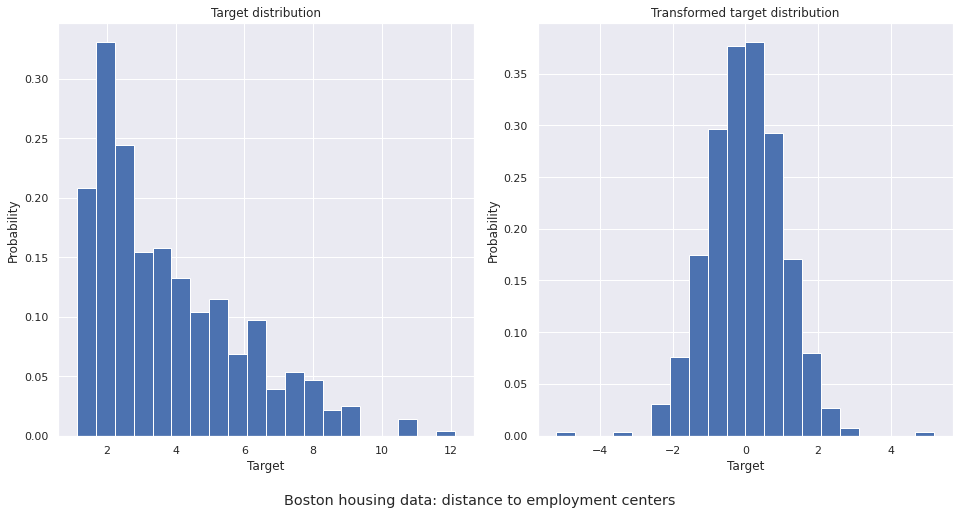

In [45]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,8))

ax0.hist(y, bins=20, density=True)
ax0.set_ylabel('Probability')
ax0.set_xlabel('Target')
ax0.set_title('Target distribution')

ax1.hist(y_trans, bins=20, density=True)
ax1.set_ylabel('Probability')
ax1.set_xlabel('Target')
ax1.set_title('Transformed target distribution')

f.suptitle("Boston housing data: distance to employment centers", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

Test MAE without target transformation = 0.8837
Test RMSE without target transformation = 1.1565
Test MAE with target transformation = 0.8093
Test RMSE with target transformation = 1.1548


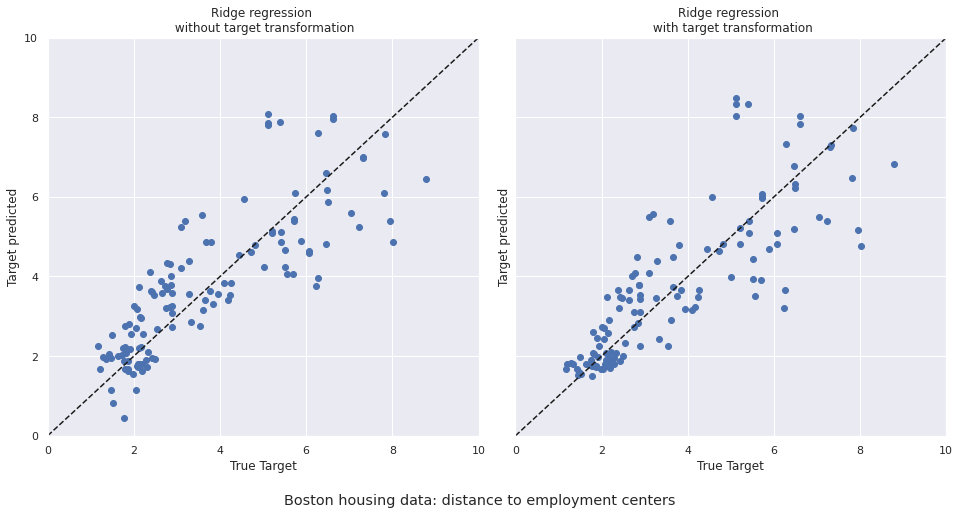

In [46]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True, figsize=(15,8))

regr = RidgeCV()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

print("Test MAE without target transformation = %.4f" % mean_absolute_error(y_test, y_pred))
print("Test RMSE without target transformation = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

ax0.scatter(y_test, y_pred)
ax0.plot([0, 10], [0, 10], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('Ridge regression \n without target transformation')
ax0.set_xlim([0, 10])
ax0.set_ylim([0, 10])

regr_trans = TransformedTargetRegressor(
    regressor=RidgeCV(),
    transformer=QuantileTransformer(n_quantiles=300,
                                    output_distribution='normal'))
regr_trans.fit(X_train, y_train)
y_pred = regr_trans.predict(X_test)

print("Test MAE with target transformation = %.4f" % mean_absolute_error(y_test, y_pred))
print("Test RMSE with target transformation = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

ax1.scatter(y_test, y_pred)
ax1.plot([0, 10], [0, 10], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Ridge regression \n with target transformation')
ax1.set_xlim([0, 10])
ax1.set_ylim([0, 10])

f.suptitle("Boston housing data: distance to employment centers", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])